In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

## Text Classification Example:  Sentiment Analysis with IMDb Movie Reviews

We will begin by importing some required modules for performing text classification in *ktrain*.

In [2]:
import ktrain
from ktrain import text

Using TensorFlow backend.



Next, we use the ```texts_from_folder``` function to load documents as fixed-length sequences of word IDs from a folder of raw documents.  This function assumes a directory structure like the following:

```
    ├── datadir
    │   ├── train
    │   │   ├── class0       # folder containing documents of class 0
    │   │   ├── class1       # folder containing documents of class 1
    │   │   ├── class2       # folder containing documents of class 2
    │   │   └── classN       # folder containing documents of class N
    │   └── test 
    │       ├── class0       # folder containing documents of class 0
    │       ├── class1       # folder containing documents of class 1
    │       ├── class2       # folder containing documents of class 2
    │       └── classN       # folder containing documents of class N
```

Each subfolder will contain documents in plain text format (e.g., `.txt` files) pertaining to the class represented by the subfolder.

For our text classification example, we will again classifiy IMDb movie reviews as either positive or negative.  However, instead of using the pre-processed version of the dataset pre-packaged with Keras, we will use the original (or raw) *aclImdb* dataset.  The dataset can be downloaded from [here](http://ai.stanford.edu/~amaas/data/sentiment/). Set the ```DATADIR``` variable to the location of the extracted *aclImdb* folder.

In the cell below, note that we supplied `preprocess_mode='standard'` to the data-loading function (which is the default).  For pretrained models like BERT, the dataset must be preprocessed in a specific way.  If you are planning to use BERT for text classification, you should replace this argument with `preprocess_mode='bert'`. Since we will not be using BERT in this example, we leave it as `preprocess_mode='standard'`.  See [this notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb) for an example of how to use BERT for text classification in *ktrain*.

In [3]:
# load training and validation data from a folder
DATADIR = 'data/aclImdb'
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(DATADIR, 
                                                                         max_features=80000, maxlen=2000, 
                                                                         ngram_range=3, 
                                                                         preprocess_mode='standard',
                                                                         classes=['pos', 'neg'])

Word Counts: 88582
Nrows: 25000
25000 train sequences
Average train sequence length: 237
Adding 3-gram features
max_features changed to 5151281 with addition of ngrams
Average train sequence length with ngrams: 709
x_train shape: (25000,2000)
y_train shape: (25000,2)
25000 test sequences
Average test sequence length: 229
Average test sequence length with ngrams: 523
x_test shape: (25000,2000)
y_test shape: (25000,2)


Having loaded the data, we employ the default text classification model in *ktrain* with the ```text_classifier``` function. The ```text_classifier``` function returns a [neural implementation of NBSVM](https://medium.com/@asmaiya/a-neural-implementation-of-nbsvm-in-keras-d4ef8c96cb7c), which is a strong baseline that can outperform more complex neural architectures. It may take a few moments to return as it builds a document-term matrix from the input data we provide it. The ```text_classifier```  function expects x_train to be a numpy array with each document represented as fixed-size sequence of word IDs.

In [4]:
text.print_text_classifiers()

fasttext: a fastText-like model (http://arxiv.org/pdf/1607.01759.pdf)
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model (http://www.aclweb.org/anthology/P12-2018)
bigru: Bidirectional GRU with pretrained word vectors
bert: Bidirectional Encoder Representations from Transformers (https://arxiv.org/abs/1810.04805)


In [5]:
# load an NBSVM model
model = text.text_classifier('nbsvm', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
compiling word ID features...
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-25000
computing log-count ratios...
done.


Next, we instantiate a Learner object and call the ```lr_find``` and ```lr_plot``` methods to help identify a good learning rate.

In [6]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

In [25]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
25000/25000 [==============================] - 6s 226us/step - loss: 0.6906 - acc: 0.5797
Epoch 2/5
25000/25000 [==============================] - 5s 206us/step - loss: 0.6071 - acc: 0.9114
Epoch 3/5
25000/25000 [==============================] - 5s 205us/step - loss: 0.2151 - acc: 0.9711
Epoch 4/5
16032/25000 [==================>...........] - ETA: 1s - loss: 0.0252 - acc: 0.9943

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


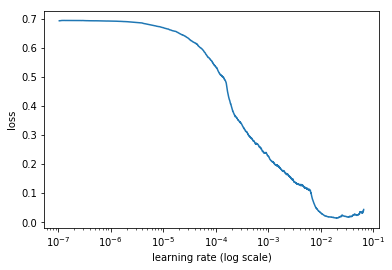

In [26]:
learner.lr_plot()

Finally, we will fit our model using and  [SGDR learning rate schedule](https://github.com/amaiya/ktrain/blob/master/example-02-tuning-learning-rates.ipynb) by invoking the ```fit``` method with the *cycle_len* parameter (along with the *cycle_mult* parameter).

In [27]:
learner.fit(0.001, 3, cycle_len=1, cycle_mult=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/7
25000/25000 [==============================] - 7s 263us/step - loss: 0.2105 - acc: 0.9461 - val_loss: 0.2481 - val_acc: 0.9187
Epoch 2/7
25000/25000 [==============================] - 7s 261us/step - loss: 0.0458 - acc: 0.9936 - val_loss: 0.2266 - val_acc: 0.9218
Epoch 3/7
25000/25000 [==============================] - 6s 257us/step - loss: 0.0082 - acc: 0.9999 - val_loss: 0.2236 - val_acc: 0.9228
Epoch 4/7
25000/25000 [==============================] - 6s 256us/step - loss: 0.0069 - acc: 0.9999 - val_loss: 0.2169 - val_acc: 0.9227
Epoch 5/7
25000/25000 [==============================] - 6s 259us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.2148 - val_acc: 0.9227
Epoch 6/7
25000/25000 [==============================] - 7s 261us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.2142 - val_acc: 0.9228
Epoch 7/7
25000/25000 [==============================] - 6s 255us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2141 - val_acc

#### As can be seen, our final model yields a validation accuracy of 92.27%.

### Making Predictions

Let's predict the sntiment of new movie reviews (or comments in this case) using our trained model.

The ```preproc``` object (returned by ```texts_from_folder```) is important here, as it is used to preprocess data in a way our model expects.

In [8]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [20]:
data = [ 'This movie was horrible! The plot was boring. Acting was okay, though.',
         'The film really sucked. I want my money back.',
        'What a beautiful romantic comedy. 10/10 would see again!']

In [21]:
predictor.predict(data)

['neg', 'neg', 'pos']

As can be seen, our model returns predictions that appear to be correct. The predictor instance can also be used to return "probabilities" of our predictions with respect to each class.  Let us first print the classes and their order.  The class *pos* stands for positive sentiment and *neg* stands for negative sentiment. Then, we will re-run ```predictor.predict``` with *return_proba=True* to see the probabilities.

In [22]:
predictor.get_classes()

['neg', 'pos']

In [23]:
predictor.predict(data, return_proba=True)

array([[0.81179327, 0.18820675],
       [0.7463994 , 0.25360066],
       [0.26558533, 0.7344147 ]], dtype=float32)


Our movie review sentiment predictor can be saved to disk and reloaded/re-used later as part of an application.  This is illustrated below:

In [14]:
predictor.save('/tmp/my_moviereview_predictor')

In [15]:
predictor = ktrain.load_predictor('/tmp/my_moviereview_predictor')

In [17]:
predictor.predict(['Groundhog Day is my favorite movie of all time!'])

['pos']

## Multi-Label Text Classification:  Identifying Toxic Online Comments

In the previous example, the classes (or categories) were mutually exclusive. By contrast, in multi-label text classification, a document or text snippet can belong to multiple classes. Here, we will classify Wikipedia comments into one or more categories of so-called *toxic comments*.   Categories of toxic online behavior include toxic, severe_toxic, obscene, threat, insult, and identity_hate.  The dataset can be downloaded from the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) as a CSV file (i.e., download the file ```train.csv```).  We will load the data using the ```texts_from_csv``` function.  This function expects one column to contain the texts of documents and one or more other columns to store the labels.  Labels can be in any of the following formats:

```
1. one-hot-encoded or multi-hot-encoded arrays representing classes:
    Example with label_columns=['positive', 'negative'] and text_column='text':
         text|positive|negative
         I like this movie.|1|0
         I hated this movie.|0|1
    Classification will have a single one in each row: [[1,0,0], [0,1,0]]]
    Multi-label classification will have one more ones in each row: [[1,1,0], [0,1,1]]
2. labels are in a single column of string or integer values representing classs labels
   Example with label_columns=['label'] and text_column='text':
      text|label
      I like this movie.|positive
      I hated this movie.|negative
```

Since the Toxic Comment Classification Challenge is a multi-label problem, we must use the first format, where labels are already multi-hot-encoded. Luckily, the `train.csv` file for this problem is already multi-hot-encoded, so no extra processing is required.  

Since `val_filepath is None`, 10% of the data will automatically be used as a validation set.


In [14]:
DATA_PATH = 'data/toxic-comments/train.csv'
NUM_WORDS = 50000
MAXLEN = 150
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_csv(DATA_PATH,
                      'comment_text',
                      label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1)

Word Counts: 197340
Nrows: 143613
143613 train sequences
Average train sequence length: 66
15958 test sequences
Average test sequence length: 66
Pad sequences (samples x time)
x_train shape: (143613,150)
x_test shape: (15958,150)
y_train shape: (143613,6)
y_test shape: (15958,6)


Next, as before, we load a text classification model and wrap the model and data in Learner object.  Instead of using the NBSVM model, we will explicitly request a different model called fasttext using the ```name``` parameter of ```text_classifier```.  The fastText architecture was created by [Facebook](https://arxiv.org/abs/1607.01759) in 2016. (You can call the ```print_textmodels``` to show the available text classification models.) 

In [15]:
text.print_text_classifiers()

nbsvm: NBSVM model (http://www.aclweb.org/anthology/P12-2018)
fasttext: a fastText-like model (http://arxiv.org/pdf/1607.01759.pdf)
logreg: logistic regression


In [20]:
model = text.text_classifier('fasttext', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

Is Multi-Label? True
compiling word ID features...
done.


As before, we use our learning rate finder to find a good learning rate. In this case, a learning rate of 0.0007 appears to be good.

In [21]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
143613/143613 [==============================] - 47s 325us/step - loss: 0.7361 - acc: 0.5322
Epoch 2/5
143613/143613 [==============================] - 46s 323us/step - loss: 0.4683 - acc: 0.7714
Epoch 3/5
143613/143613 [==============================] - 46s 323us/step - loss: 0.0879 - acc: 0.9729
Epoch 4/5
143613/143613 [==============================] - 46s 323us/step - loss: 0.1106 - acc: 0.9686
Epoch 5/5
143613/143613 [==============================] - 46s 323us/step - loss: 0.1636 - acc: 0.9629


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


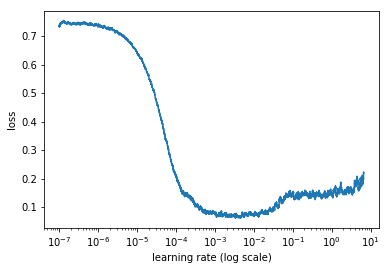

In [23]:
learner.lr_plot()

Finally, we will train our model for 8 epochs using ```autofit``` with a learning rate of 0.0007. Having explicitly specified the number of epochs, ```autofit``` will automatically employ a triangular learning rate policy. Our final ROC-AUC score is **0.98**.

As shown in [this example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb) on our GitHub project, even better results can be obtained using a Bidirectional GRU with pretrained word vectors (called ‘bigru’ in ktrain)

In [24]:
learner.autofit(0.0007, 8)



begin training using triangular learning rate policy with max lr of 0.0007...
Train on 143613 samples, validate on 15958 samples
Epoch 1/8
143613/143613 [==============================] - 48s 333us/step - loss: 0.1140 - acc: 0.9630 - val_loss: 0.0530 - val_acc: 0.9812
Epoch 2/8
143613/143613 [==============================] - 47s 330us/step - loss: 0.0625 - acc: 0.9790 - val_loss: 0.0501 - val_acc: 0.9819
Epoch 3/8
143613/143613 [==============================] - 48s 331us/step - loss: 0.0572 - acc: 0.9801 - val_loss: 0.0491 - val_acc: 0.9821
Epoch 4/8
143613/143613 [==============================] - 47s 331us/step - loss: 0.0538 - acc: 0.9806 - val_loss: 0.0481 - val_acc: 0.9823
Epoch 5/8
143613/143613 [==============================] - 47s 329us/step - loss: 0.0517 - acc: 0.9813 - val_loss: 0.0476 - val_acc: 0.9823
Epoch 6/8
143613/143613 [==============================] - 47s 329us/step - loss: 0.0501 - acc: 0.9815 - val_loss: 0.0470 - val_acc: 0.9825
Epoch 7/8
143613/143613 [====

#### Let's compute for ROC-AUC of our final model for identifying toxic online behavior:

In [25]:
from sklearn.metrics import roc_auc_score
y_pred = learner.model.predict(x_test, verbose=0)
score = roc_auc_score(y_test, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.980092 



### Making Predictions

As before, let's make some predictions about toxic comments using our model by wrapping it in a Predictor instance.

In [26]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [30]:
# correctly predict a toxic comment that includes a threat
predictor.predict(["If you don't stop immediately, I will kill you."])

[[('toxic', 0.5491581),
  ('severe_toxic', 0.02454061),
  ('obscene', 0.084347874),
  ('threat', 0.4110818),
  ('insult', 0.17229997),
  ('identity_hate', 0.08519211)]]

In [36]:
# non-toxic comment
predictor.predict(["Okay - I'm calling it a night. See you tomorrow."])

[[('toxic', 0.021799222),
  ('severe_toxic', 7.991817e-07),
  ('obscene', 0.000504758),
  ('threat', 5.477591e-05),
  ('insult', 0.001496369),
  ('identity_hate', 9.472556e-05)]]

In [31]:
predictor.save('/tmp/toxic_detector')

In [33]:
predictor = ktrain.load_predictor('/tmp/toxic_detector')

In [45]:
# model works correctly and as expected after reloading from disk
predictor.predict(["You have a really ugly face."])

[[('toxic', 0.86799675),
  ('severe_toxic', 0.008107864),
  ('obscene', 0.26740596),
  ('threat', 0.006626291),
  ('insult', 0.39607796),
  ('identity_hate', 0.023489485)]]

## The `Transformers` API in *ktrain*

If using transformer models like BERT or DistilBert, *ktrain* includes an alternative API for text classification that can be used as follows:

```python
import ktrain
from ktrain import text
MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500,  
                     classes=label_list)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner.fit_onecycle(3e-5, 1)
```

For more information, see our tutorial on [text classification with Hugging Face Transformers](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb).

You may be also interested in some of our blog posts on text classification:
- [Text Classification With Hugging Face Transformers in TensorFlow 2 (Without Tears)](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed)
- [BERT Text Classification in 3 Lines of Code](https://towardsdatascience.com/bert-text-classification-in-3-lines-of-code-using-keras-264db7e7a358)